# Visualize deformation results (test deformer module)

## Imports and Utility function for rendering

In [35]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch3d.structures import join_meshes_as_batch, Meshes
from pytorch3d.renderer import (
            PerspectiveCameras, RasterizationSettings,
            DirectionalLights, MeshRasterizer, MeshRenderer, HardFlatShader, 
            TexturesVertex
)
sys.path.append(os.path.join(os.getcwd(), ".."))

In [37]:
NUM_SHELLS = 5

In [39]:
def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.norm(vectors, dim=-1, keepdim=True))
    
def create_cam2world_matrix(forward_vector, origin):
    """Takes in the direction the camera is pointing and the camera origin and returns a cam2world matrix."""
    forward_vector = normalize_vecs(forward_vector)
    up_vector = torch.tensor([0, 1, 0], dtype=torch.float, device=origin.device).expand_as(forward_vector)

    right_vector = -normalize_vecs(torch.cross(up_vector, forward_vector, dim=-1))
    up_vector = normalize_vecs(torch.cross(forward_vector, right_vector, dim=-1))

    rotation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    rotation_matrix[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), axis=-1)

    translation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    translation_matrix[:, :3, 3] = origin
    cam2world = (translation_matrix @ rotation_matrix)[:, :, :]
    assert(cam2world.shape[1:] == (4, 4))
    return cam2world

class LookAtPoseSampler:

    @staticmethod
    def sample(horizontal_mean, vertical_mean, lookat_position, horizontal_stddev=0, vertical_stddev=0, radius=1, batch_size=1, device='cpu'):
        h = torch.randn((batch_size, 1), device=device) * horizontal_stddev + horizontal_mean
        v = torch.randn((batch_size, 1), device=device) * vertical_stddev + vertical_mean
        v = torch.clamp(v, 1e-5, math.pi - 1e-5)

        theta = h
        v = v / math.pi
        phi = torch.arccos(1 - 2*v)

        camera_origins = torch.zeros((batch_size, 3), device=device)

        camera_origins[:, 0:1] = radius*torch.sin(phi) * torch.cos(math.pi-theta)
        camera_origins[:, 2:3] = radius*torch.sin(phi) * torch.sin(math.pi-theta)
        camera_origins[:, 1:2] = radius*torch.cos(phi)

        # forward_vectors = normalize_vecs(-camera_origins)
        forward_vectors = normalize_vecs(lookat_position - camera_origins)
        return create_cam2world_matrix(forward_vectors, camera_origins)
        

def setup_cameras(device, img_size=None, pose=None, intrinsics=None):
    if intrinsics is None:
        focal_length = 4.2647 * 2
        intrinsics = torch.zeros((4, 4), device=device)
        intrinsics[[0, 1], [0, 1]] = -focal_length
        intrinsics[2, 3] = 1.0
        intrinsics[3, 2] = 1.0
        intrinsics = intrinsics[None]
    else:
        raise NotImplementedError

    if pose is None:
        yaw = 0.0
        pitch = 0.2
        pose = LookAtPoseSampler.sample(3.14/2 + yaw, 3.14/2 + pitch, torch.tensor([0, 0, 0.2]), radius=2.6)
    else:
        pose = pose.reshape(-1, 4, 4)

    world2cam = pose.clone()
    # world2cam[:, [0, 1]] *= -1
    # world2cam = -1 * world2cam
    world2cam = world2cam.inverse()
    # intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]])
    cameras = PerspectiveCameras(device=device, R=world2cam[:, :3, :3], T=world2cam[:, :3, 3],
                                 K=intrinsics, in_ndc=True)
    return cameras

device = "cuda"
img_size = 256
pose = None
cameras = setup_cameras(device, img_size=img_size, pose=pose)
raster_settings = RasterizationSettings(
    image_size=img_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)
mesh_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(
        device=device,
        cameras=cameras,
        lights=DirectionalLights(device=device,
                                 ambient_color=((0.2, 0.2, 0.2),),
                                 diffuse_color=((0.6, 0.6, 0.8),),
                                 specular_color=((0.2, 0.2, 0.0),),
                                 direction=[[0.5,1,1.5]])
    )
)

def render_meshes(meshes, cameras):
    MESH_COLOR = [50, 168, 168]    
    verts_rgb = torch.ones_like(meshes.verts_padded()).to(device)
    verts_rgb[...,0] = MESH_COLOR[0]/255
    verts_rgb[...,1] = MESH_COLOR[1]/255
    verts_rgb[...,2] = MESH_COLOR[2]/255
    meshes.textures = TexturesVertex(verts_features=verts_rgb)
    mesh_img = mesh_renderer(meshes, cameras=cameras)[:,:,:,:3]
    mesh_img = (mesh_img * 255).clamp(0, 255).to(torch.uint8).cpu().numpy()
    return mesh_img

## Set up correspondences

In [54]:
import torch

from deformer.smpl_deformer import Deformer, flame_init_kwargs
from deformer.util import (get_shell_verts_from_base,                                     
                           point_mesh_barycentric_coordinates,
                           weights_from_k_closest_verts,
                           PointMeshCorrespondence,
                           )
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj, save_obj

TEMPLATE_SCALE = 2.9
TEMPLATE_TRANS = [0, 0.04, 0.12]
ASSET_DIR = "../assets"
PATH_BASE = os.path.join(ASSET_DIR, 'flame_uv_no_back_close_mouth_no_subdivision.obj')
deformer = Deformer(**flame_init_kwargs, 
                    scale=TEMPLATE_SCALE,
                    transl=torch.tensor(TEMPLATE_TRANS))

device = "cuda"
deformer.smplx_model = deformer.smplx_model.to(device)

smpl_template_verts = deformer.smplx_model().vertices
save_obj('./flame_template.obj', smpl_template_verts.detach().cpu()[0], deformer.smplx_model.faces_tensor.detach().cpu())

shell_base_verts, shell_faces, aux = load_obj(PATH_BASE, load_textures=False)
shell_base_verts = shell_base_verts * TEMPLATE_SCALE
shell_base_verts += torch.tensor([TEMPLATE_TRANS])
shell_faces = shell_faces.verts_idx.to(device=device)
shell_base_verts = shell_base_verts[None]
shell_base_verts = shell_base_verts.to(device=device)
shell_base_vnormals = Meshes(shell_base_verts, shell_faces[None]).verts_normals_padded()

# Implementation of 1
# Deform the shell using closest k points. Compute correspondence for all shells using the base custom template and flame template
shell_vertices = get_shell_verts_from_base(
    shell_base_verts,
    deformer.smplx_model.faces_tensor,
    offset_len=0.03,
    num_shells=NUM_SHELLS,
)
shell_v_template = get_shell_verts_from_base(
    smpl_template_verts,
    deformer.smplx_model.faces_tensor,
    offset_len=0.03,
    num_shells=NUM_SHELLS,
)
shell_vnormals = Meshes(shell_vertices[0], shell_faces[None].expand(NUM_SHELLS, -1, -1)).verts_normals_padded()
smpl_template_vnormals = Meshes(smpl_template_verts, deformer.smplx_model.faces_tensor[None]).verts_normals_padded()
point_verts_weights, point_verts_idxs = weights_from_k_closest_verts(
    shell_vertices[0],
    shell_v_template[0], 
    k=5,
    points_normals=shell_vnormals,
    verts_normals=smpl_template_vnormals,
    normal_weight=0.1,    
)

# Implementation of 2
# compute correspondence for each shell between each custom template and flame template
# inflating templates
shell_vnormals = Meshes(shell_vertices[0], shell_faces[None].expand(NUM_SHELLS, -1, -1)).verts_normals_padded()
shell_bary_coords_m2, face_idxs_m2 = point_mesh_barycentric_coordinates(
    shell_vertices[0],
    shell_v_template[0], 
    deformer.smplx_model.faces_tensor,
    # point_normals=shell_vnormals,
    return_packed=False,
)

## Visualize correspondence

In [63]:
from pytorch3d.ops import knn_gather
smpl_template_verts= smpl_template_verts.cuda()
# Visualize barycentric lookups before deformation
src_batch_size, num_points = face_idxs_m2.shape[:2]
# closest vertex index per point
point_verts_idxs = torch.cat(
    [deformer.smplx_model.faces_tensor[idxs] for idxs in face_idxs_m2]
).reshape(src_batch_size, num_points, 3)
# closest vertex locations per point
points_verts = knn_gather(smpl_template_verts.expand(NUM_SHELLS, -1, -1), point_verts_idxs)
src_verts = torch.einsum("npk,npkl->npl", shell_bary_coords_m2, points_verts)

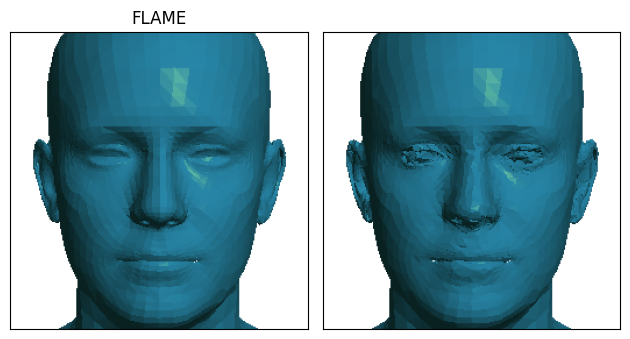

In [64]:

shells_init = Meshes(torch.cat([shell_base_verts, src_verts], 0), shell_faces[None].expand(src_verts.shape[0]+shell_base_verts.shape[0], -1, -1))
mesh_img = render_meshes(shells_init, cameras=cameras)

fig, axs = plt.subplots(1, len(shells_init))
fig.set_tight_layout(True)
for i, ax in enumerate(axs):
    ax.imshow(mesh_img[i])
    if i == 0:
        ax.set_title('FLAME')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

plt.show()

# Visualization

## First Part: visualize shell meshes

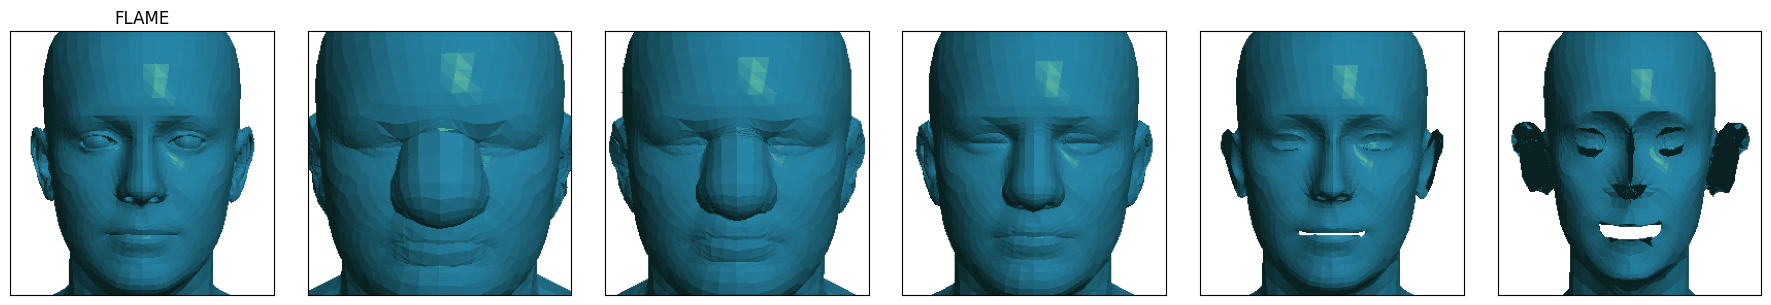

In [57]:
MESH_COLOR = [50, 168, 168]
shells_init = Meshes([smpl_template_verts[0].cuda()] + list(torch.unbind(shell_vertices[0], dim=0)), [deformer.smplx_model.faces_tensor] + [shell_faces]*NUM_SHELLS)
mesh_img = render_meshes(shells_init, cameras=cameras)

fig, axs = plt.subplots(1, 6, figsize=(18, 3))
fig.set_tight_layout(True)
for i, ax in enumerate(axs):
    ax.imshow(mesh_img[i])
    if i == 0:
        ax.set_title('FLAME')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

plt.show()

## Visualize shell deformation

In [67]:
# Internal function to generate images based on attributes
# tmp = np.random.rand(img_size, img_size)
@torch.no_grad()
def render_internal(exp_params, shp_params, pose_params):
    # # Create 6 images (512x512) based on the attributes       
    # images = [tmp * a for a in exp_params[:6]]
    # print("debug", exp_params[:10])
    # return images
    exp_params = torch.from_numpy(exp_params).to(device, dtype=torch.float32).reshape([1, -1])
    shp_params = torch.from_numpy(shp_params).to(device, dtype=torch.float32).reshape([1, -1])
    pose_params = torch.from_numpy(pose_params).to(device, dtype=torch.float32).reshape([1, -1])    
    _, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),
        expression=exp_params.expand(NUM_SHELLS, -1),
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        jaw_pose=pose_params[:, 3:6].expand(NUM_SHELLS, -1),
        neck_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        leye_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        reye_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3
        bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
        point_verts_idxs=point_verts_idxs,
        point_verts_weights=point_verts_weights,
        # src_verts=shell_vertices.reshape(1, NUM_SHELLS*shell_vertices.shape[2], 3),
    )
    shell_deformed_verts = shell_deformed_verts.reshape(NUM_SHELLS, shell_vertices.shape[-2], 3)
    images_m1 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    outputs, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),
        expression=exp_params.expand(NUM_SHELLS, -1),
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        jaw_pose=pose_params[:, 3:6].expand(NUM_SHELLS, -1),
        neck_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        leye_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        reye_pose=torch.zeros((NUM_SHELLS, 3), dtype=torch.float32, device=pose_params.device),
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3
        bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
        point_face_idxs=face_idxs_m2,
        # src_verts=shell_vertices[0],
    )
    flame_deformed_verts = outputs.vertices
    images_m2_template = render_meshes(Meshes(flame_deformed_verts, deformer.smplx_model.faces_tensor[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    images_m2 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    return ("m1", images_m1), ("m2 template", images_m2_template), ("m2", images_m2), shell_deformed_verts

# Initialize output widget
out = widgets.Output()

# Render function
def render(*args):
    exp_params = np.concatenate([np.array([slider.value for slider in slider_set_expression]), np.zeros(deformer.smplx_model.num_expression_coeffs-10)])
    shp_params = np.concatenate([np.array([slider.value for slider in slider_set_shape]), np.zeros(deformer.smplx_model.num_betas-10)])
    pose_params = np.array([slider.value for slider in slider_set_pose])    
    
    image_sets = render_internal(exp_params, shp_params, pose_params)    
    with out:
        tmp = image_sets[-1].flatten().cpu().numpy()[:10]
        image_sets = image_sets[:-1]
        clear_output(wait=True)
        fig, axs = plt.subplots(len(image_sets), len(image_sets[0][1]), figsize=(3*len(image_sets[0][1]), 3*len(image_sets)))
        for row, image_set in enumerate(image_sets):
            label = image_set[0]
            image_set = image_set[1]
            for col, image in enumerate(image_set):                
                ax = axs[row, col]
                ax.imshow(image)
                ax.axes.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([])
        plt.show()
        print(tmp)

# Creating 3 sets of 10 sliders
sliders = []
slider_set_expression = [widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=f'exp_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_expression):
    slider.observe(render, names=f'value')
sliders.append(slider_set_expression)
slider_set_shape = [widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description=f'sh_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_shape):
    slider.observe(render, names=f'value')
sliders.append(slider_set_shape)
slider_set_pose = [widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description=f'pose_{id:03d}', continuous_update=False) for id in range(6)]
for id, slider in enumerate(slider_set_pose):
    slider.observe(render, names=f'value')
sliders.append(slider_set_pose)

# Group sliders visually
slider_boxes = [widgets.VBox(slider_set) for slider_set in sliders]
slider_group = widgets.HBox(slider_boxes)

# Display the sliders and output
display(out, slider_group)

%pdb off
# Initial Rendering
render()

Output()

Automatic pdb calling has been turned OFF


## Next Part: Deform trained Gaussians

In [ ]:
# Load training result
from gaussian_renderer import GaussianModel
import pickle
import torch.nn as nn
from gaussian_renderer import render as render_gaussian

class points:
    def __init__(self, coordinates= [], upper_traingle= [], lower_traingle= [], upper_uv= [], lower_uv= [], tet_bari= [], tex_up= [], tex_low= [], 
                 z_0 = [], z = [], z_1 = [], faces = []):
        self.coordinates = coordinates
        self.upper_traingle = upper_traingle
        self.lower_traingle = lower_traingle
        self.upper_uv = upper_uv
        self.lower_uv = lower_uv
        self.tet_bari = tet_bari
        self.tex_up = tex_up
        self.tex_low = tex_low
        self.z_0 = z_0
        self.z = z
        self.z_1 = z_1
        self.faces = faces

class Camera(nn.Module):
    def __init__(self, 
                 id__,
                 R, T, FoVx, FoVy, 
                 # image, gt_alpha_mask,
                 # image_name, 
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        # self.uid = uid
        # self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.image_width = 512
        self.image_height = 512

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]
        
with open('../output/gaussians.pkl', 'rb') as f:
  gaussians = pickle.load(f)

with open('../output/point_list.pkl', 'rb') as f:
  points_list = pickle.load(f)

with open('../output/camera.pkl', 'rb') as f:
  camera = pickle.load(f)

# Lookup functions to move the gaussians, which lie on the triangles
print('Points:', points_list.coordinates.shape)
print('Faces_per_point:', points_list.faces.shape)
print('uvw_per_point', points_list.upper_uv.shape)
print('texture_ccord_per_point', points_list.tex_up.shape)

# Given the face indices, find the vertices of the triangles
def indexed_tensor(faces, vertices):
    # Extract the indices for each vertex in a face
    indices = faces.view(-1)
    
    # Use torch.index_select to get the indexed tensor
    indexed_tensor = torch.index_select(vertices, dim=0, index=indices)
    
    # Reshape the indexed tensor to match the original faces shape
    indexed_tensor = indexed_tensor.view(faces.shape[0], faces.shape[1], -1)

    return indexed_tensor

# Find the points using baricentric interpolation
def combine_vertices(indexed_tensor, weights):
    # Make sure the shapes are compatible
    assert indexed_tensor.shape[0] == weights.shape[0]
    
    # Expand the weights tensor to have the same shape as indexed_tensor
    expanded_weights = weights.unsqueeze(2)
    
    # Multiply the indexed tensor by the expanded weights and sum along the second dimension
    combined_tensor = torch.sum(indexed_tensor * expanded_weights, dim=1)
    
    return combined_tensor

Points: torch.Size([28016, 3])
Faces_per_point: torch.Size([28016, 3])
uvw_per_point torch.Size([28016, 3])
texture_ccord_per_point torch.Size([28016, 2])


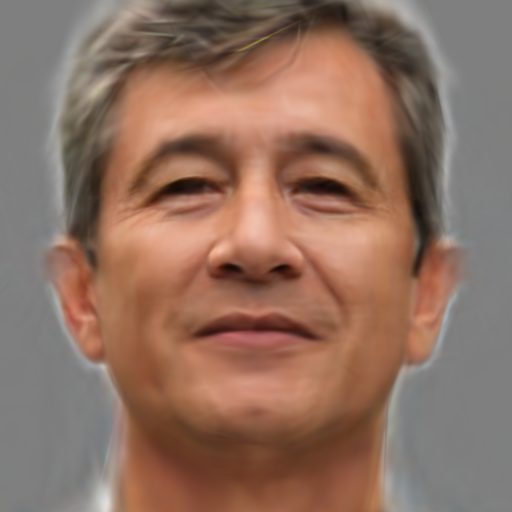

In [ ]:
from PIL import Image
from utils.graphics_utils import fov2focal,focal2fov, getWorld2View2, getProjectionMatrix
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import PointsRenderer, PointsRasterizationSettings, PointsRasterizer, AlphaCompositor


bg_color = [0.5, 0.5, 0.5]
background = torch.tensor(bg_color, dtype=torch.float32, device= 'cuda:0')
fov_deg = 18.837
fovx = np.deg2rad(fov_deg)
img_width = img_height = 512
fovy = focal2fov(fov2focal(fovx, img_width), img_height)
FovX = FovY = fovx
extrinsic = np.load('../data/seed0021_zavelstein_2k_movcam_poses.npy')
extrinsic = extrinsic[..., :16].reshape(-1, 4, 4)

camera_id = 0
camera =  Camera(camera_id, extrinsic[camera_id][:3,:3], np.linalg.inv(extrinsic[camera_id])[:3, 3], FovX, FovY, data_device="cuda")

class PipelineParams():
    def __init__(self):
        self.convert_SHs_python = True
        self.compute_cov3D_python = False
        self.debug = False

pipeline = PipelineParams()

rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)
display(Image.fromarray(np.concatenate([im], axis=1)))


In [ ]:
def deform_gaussians_from_shell_vertices(shell_vertices, faces, upper_uv):
    """
        Args: shell_vertices: (V, 3)
    """    
    #These are the new triangles where the faces are the same by the vertex values are different
    tris = indexed_tensor(faces, shell_vertices)
    
    # Do the interpolation based on the saved uvw to generate dispalcement in the points
    new_coordinates  = combine_vertices(tris, upper_uv)

    return new_coordinates

exp_params = torch.zeros((1, deformer.n_expression_params), device=device, dtype=torch.float32)
shp_params = torch.zeros((1, deformer.n_shape_params), device=device, dtype=torch.float32)
pose_params = torch.zeros((1, deformer.n_pose_params), device=device, dtype=torch.float32)

shell_vertices_x_streched = shell_vertices.clone()
shell_vertices_x_streched[...,0] = shell_vertices_x_streched[...,0] * 1.5
shell_v_template_x_stretched = shell_v_template.clone()
shell_v_template_x_stretched[...,0] = 1.5*shell_v_template_x_stretched[...,0]
flame_deformed_verts, shell_landmarks, shell_deformed_verts = deformer.run(
            shape_params=shp_params.expand(NUM_SHELLS, -1),
            expression_params=exp_params.expand(NUM_SHELLS, -1),
            pose_params=pose_params.expand(NUM_SHELLS, -1),
            v_template=shell_v_template_x_stretched[0],
            bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
            point_face_idxs=face_idxs_m2,
            src_verts=shell_vertices_x_streched[0],
        )   
shell_deformed_verts = shell_deformed_verts.reshape(-1, 3)
assert shell_deformed_verts.shape == (17765, 3)

new_xyz = deform_gaussians_from_shell_vertices(shell_deformed_verts.reshape(-1, 3).cpu(), points_list.faces, points_list.upper_uv)
assert new_xyz.shape == gaussians.get_xyz.shape
gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)

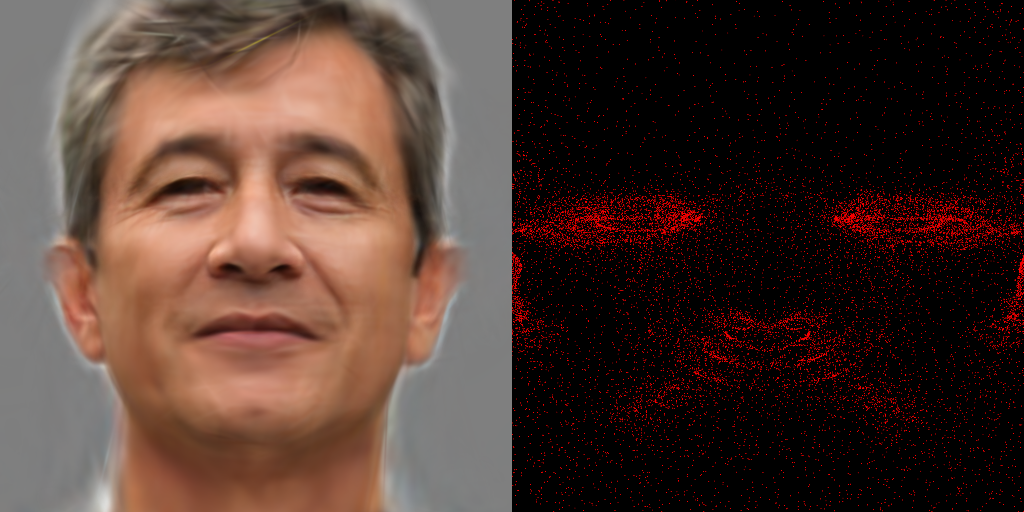

In [ ]:
rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)

raster_settings = PointsRasterizationSettings(
    image_size=(img_height, img_width), 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
point_renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
pnt_rgb = torch.zeros_like(gaussians.get_xyz)
pnt_rgb[..., 0] = 1.0
point_cloud = Pointclouds(points=[gaussians.get_xyz], features=[pnt_rgb])
pnts_img = np.uint8(point_renderer(point_cloud, cameras=cameras)[0].cpu().numpy()*255)
display(Image.fromarray(np.concatenate([im, pnts_img], axis=1)))

## Visualize interactively

In [ ]:
from gaussian_renderer import render as render_gaussian
from pytorch3d.renderer import PointsRenderer

def render_gaussian_f(gaussians, camera):
    rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
    im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)
    return im

def render_gaussian_p(gaussians, camera):
    pnt_rgb = torch.zeros_like(gaussians.get_xyz)
    pnt_rgb[..., 0] = 1.0
    point_cloud = Pointclouds(points=[gaussians.get_xyz], features=[pnt_rgb])
    pnts_img = np.uint8(point_renderer(point_cloud, cameras=cameras)[0].cpu().numpy()*255)
    return pnts_img
    
# Internal function to generate images based on attributes
# tmp = np.random.rand(img_size, img_size)
def render_internal(exp_params, shp_params, pose_params):    
    exp_params = torch.from_numpy(exp_params).to(device, dtype=torch.float32).reshape([1, -1])
    shp_params = torch.from_numpy(shp_params).to(device, dtype=torch.float32).reshape([1, -1])
    pose_params = torch.from_numpy(pose_params).to(device, dtype=torch.float32).reshape([1, -1])
    
    shell_vertices_x_streched = shell_vertices.clone()
    shell_vertices_x_streched[...,0] = shell_vertices_x_streched[...,0] * 1.5
    flame_deformed_verts, shell_landmarks = deformer.run(
        shape_params=shp_params,
        expression_params=exp_params,
        pose_params=pose_params,
        # bary_coords=shell_bary_coords.expand(NUM_SHELLS, -1, -1).reshape(1, NUM_SHELLS * shell_bary_coords.shape[1], 3),
        # point_face_idxs=face_idxs.expand(NUM_SHELLS, -1, -1).reshape(1, NUM_SHELLS * face_idxs.shape[1]),
        # src_verts=shell_vertices_x_streched.reshape(1, NUM_SHELLS*shell_vertices_x_streched.shape[2], 3),
    )
    images_flame = render_meshes(Meshes(flame_deformed_verts, deformer.flamelayer.faces_tensor[None].expand(flame_deformed_verts.shape[0], -1, -1)), cameras=cameras)[0]
    # images_shell = render_meshes(Meshes(shell_deformed_verts[:1], shell_faces[None]), cameras=cameras)[0]
    # shell_deformed_verts = shell_deformed_verts.reshape(-1, 3)
    # assert shell_deformed_verts.shape == (17765, 3)    
    # new_xyz = deform_gaussians_from_shell_vertices(shell_deformed_verts.reshape(-1, 3).cpu(), points_list.faces, points_list.upper_uv)
    # assert new_xyz.shape == gaussians.get_xyz.shape
    # gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)    
    # images_m1 = render_gaussian_f(gaussians, camera)
    shell_v_template_x_stretched = shell_v_template.clone()
    shell_v_template_x_stretched[...,0] = 1.5*shell_v_template_x_stretched[...,0]
    flame_deformed_verts, shell_landmarks, shell_deformed_verts = deformer.run(
            shape_params=shp_params.expand(NUM_SHELLS, -1),
            expression_params=exp_params.expand(NUM_SHELLS, -1),
            pose_params=pose_params.expand(NUM_SHELLS, -1),
            v_template=shell_v_template_x_stretched[0],
            bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
            point_face_idxs=face_idxs_m2,
            # src_verts=shell_vertices_x_streched[0],
        )    
    images_shell = render_meshes(Meshes(shell_deformed_verts[:1], shell_faces[None]), cameras=cameras)[0]
    shell_deformed_verts = shell_deformed_verts.reshape(-1, 3)
    assert shell_deformed_verts.shape == (17765, 3)    
    new_xyz = deform_gaussians_from_shell_vertices(shell_deformed_verts.reshape(-1, 3).cpu(), points_list.faces, points_list.upper_uv)
    assert new_xyz.shape == gaussians.get_xyz.shape
    gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)
    # images_m2_template = render_meshes(Meshes(flame_deformed_verts, deformer.flamelayer.faces_tensor[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    # images_m2 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    images_m2 = render_gaussian_f(gaussians, camera)
    images_pnts = render_gaussian_p(gaussians, cameras)
    return ("ref", images_flame), ("shell", images_shell), ("xyz", images_pnts), ("m2", images_m2), gaussians

# Initialize output widget
out = widgets.Output()

# Render function
def render(*args):
    exp_params = np.concatenate([np.array([slider.value for slider in slider_set_expression]), np.zeros(deformer.n_expression_params-10)])
    shp_params = np.concatenate([np.array([slider.value for slider in slider_set_shape]), np.zeros(deformer.n_shape_params-10)])
    pose_params = np.array([slider.value for slider in slider_set_pose])
    images = render_internal(exp_params, shp_params, pose_params)    
    with out:
        # tmp = image_sets[:-1][1].flatten().cpu().numpy()[:10]
        images = images[:-1]
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(images), figsize=(5*len(images), 5))        
        for col, lbl_image in enumerate(images):                
            ax = axs[col]
            label, image = lbl_image
            ax.imshow(image)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            ax.set_title(label)
        plt.show()

# Creating 3 sets of 10 sliders
sliders = []
slider_set_expression = [widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=f'exp_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_expression):
    slider.observe(render, names=f'value')
sliders.append(slider_set_expression)
slider_set_shape = [widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description=f'sh_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_shape):
    slider.observe(render, names=f'value')
sliders.append(slider_set_shape)
slider_set_pose = [widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description=f'pose_{id:03d}', continuous_update=False) for id in range(6)]
for id, slider in enumerate(slider_set_pose):
    slider.observe(render, names=f'value')
sliders.append(slider_set_pose)

# Create a button for resetting sliders
reset_button = widgets.Button(description="Reset Sliders")

# Group sliders visually
slider_boxes = [widgets.VBox(slider_set) for slider_set in sliders]
slider_group = widgets.HBox(slider_boxes)

# Define function to reset all sliders to initial value
def reset_values(button):
    for slider_set in sliders:
        for slider in slider_set:
            slider.value = 0.0

# Add reset function to button click event
reset_button.on_click(reset_values)

# Display the sliders and output
display(reset_button, out, slider_group)

# Initial Rendering
render()

Button(description='Reset Sliders', style=ButtonStyle())

Output()